In [114]:
import os
import torch
import numpy as np

from PIL import Image
from torch import nn
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Resize
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import time

%matplotlib inline

In [125]:
sample_input = os.path.join(os.curdir,'..','data','preprocessed','autoencoder','val','CNV-53018-10.jpeg')

In [126]:
img =  Image.open(sample_input).convert('RGB')

In [127]:
transforms = Compose([
    Resize(224),
    ToTensor()
    ])
img  = transforms(img).unsqueeze(0)

In [109]:
class ConvBlock(nn.Module):
    def __init__(self, **kwargs):
        super(ConvBlock, self).__init__()
        
        self.block = nn.Sequential(
                nn.Conv2d(**kwargs),
                nn.BatchNorm2d(num_features=kwargs['out_channels']),
                nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        return self.block(x)
        

In [53]:
class ConvTransBlock(nn.Module):
    def __init__(self, **kwargs):
        super(ConvTransBlock, self).__init__()
        
        self.block = nn.Sequential(
                nn.ConvTranspose2d(**kwargs),
                #nn.BatchNorm2d(num_features=kwargs['out_channels']),
                nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        return self.block(x)

In [54]:
model1 = ConvBlock(in_channels= 3, out_channels = 64, kernel_size= 3,stride = 1, padding =1 )

In [55]:
x = model1(img)
x.shape

torch.Size([1, 64, 224, 224])

In [56]:
model2 = ConvTransBlock(in_channels= 64, out_channels = 3, kernel_size= 3, padding =1)

In [57]:
model2(x).shape

torch.Size([1, 3, 224, 224])

In [58]:
class VGG16AutoEncoder(nn.Module):
    def __init__(self):
        super(VGG16AutoEncoder,self).__init__()
        
        #Encoder
        self.block1 = nn.Sequential(
                ConvBlock(in_channels=  3, out_channels = 64, kernel_size= 3, padding =1),
                ConvBlock(in_channels= 64, out_channels = 64, kernel_size= 3, padding =1)
        )
        
        self.block2 = nn.Sequential(
                ConvBlock(in_channels= 64, out_channels = 128, kernel_size= 3, padding =1),
                ConvBlock(in_channels= 128, out_channels = 128, kernel_size= 3, padding =1)                
        
        )
        
        self.block3 = nn.Sequential(
                ConvBlock(in_channels= 128, out_channels = 256, kernel_size= 3, padding =1),
                ConvBlock(in_channels= 256, out_channels = 256, kernel_size= 3, padding =1),
                ConvBlock(in_channels= 256, out_channels = 256, kernel_size= 3, padding =1)
        
        )
        
        self.block4 = nn.Sequential(
                ConvBlock(in_channels= 256, out_channels = 512, kernel_size= 3, padding =1),
                ConvBlock(in_channels= 512, out_channels = 512, kernel_size= 3, padding =1),
                ConvBlock(in_channels= 512, out_channels = 512, kernel_size= 3, padding =1)
        
        )
        
        self.block5 = nn.Sequential(
                ConvBlock(in_channels= 512, out_channels = 512, kernel_size= 3, padding =1),
                ConvBlock(in_channels= 512, out_channels = 512, kernel_size= 3, padding =1),
                ConvBlock(in_channels= 512, out_channels = 512, kernel_size= 3, padding =1)
        
        )
        
        #Decoder
        self.block6 = nn.Sequential(
            
                ConvTransBlock(in_channels= 512, out_channels = 256, kernel_size= 2, stride=2),
                ConvTransBlock(in_channels= 256, out_channels = 128, kernel_size= 2, stride=2),
                ConvTransBlock(in_channels= 128, out_channels = 64,  kernel_size= 2, stride=2),
                ConvTransBlock(in_channels= 64, out_channels = 64,   kernel_size= 2, stride=2),
                ConvTransBlock(in_channels= 64, out_channels = 3,    kernel_size= 2, stride=2),
        
        
        )
        
        
        
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
    
    
    def forward(self,x):
        print(x.shape)
        x = self.block1(x)
        x = self.max_pool(x)
        x = self.block2(x)
        x = self.max_pool(x)
        x = self.block3(x)
        x = self.max_pool(x)
        x = self.block4(x)
        x = self.max_pool(x)
        x = self.block5(x)
        x = self.max_pool(x)
        x = self.block6(x) 
        return x 

In [59]:
train_data_path = os.path.join(os.curdir,'..','data','preprocessed', 'autoencoder')
val_data_path = os.path.join(os.curdir,'..','data','preprocessed', 'autoencoder')

In [60]:
class AEDataset(Dataset):
    def __init__(self, data_path, train=True ):
        if train :
            self.data_path = os.path.join(data_path, 'train')
        else:
            self.data_path = os.path.join(data_path, 'val')
        self.all_images = os.listdir(self.data_path)
        self.trasforms = Compose([
                    Resize(224),
                    ToTensor()
                    ])
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx)->torch.tensor:
        image_name = self.all_images[idx]
        path = os.path.join(self.data_path, image_name)
        return self.trasforms(Image.open(fp=path).convert('RGB'))

In [61]:
train_data = AEDataset(train_data_path,train =True)
val_data = AEDataset(val_data_path,train =False)

In [62]:
train_data[0].shape

torch.Size([3, 224, 224])

In [63]:
train_iterator = DataLoader(train_data,shuffle = True, batch_size=64)
val_iterator = DataLoader(train_data,shuffle = True, batch_size=64)

In [64]:
next(iter(train_iterator)).shape

torch.Size([64, 3, 224, 224])

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
model = VGG16AutoEncoder()

In [67]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,428,931 trainable parameters


In [68]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [69]:
criterion = nn.MSELoss()

In [70]:
model.to(device)

VGG16AutoEncoder(
  (block1): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (block2): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [71]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    
    model.train()
    
    for images in iterator:
        
        images = images.to(device)
        
        optimizer.zero_grad()
                
        output = model(images)
        
        loss = criterion(output, images)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [72]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for images in iterator:
            
            images = images.to(device)
            
            output = model(images)

            loss = criterion(output, images)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [73]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [74]:
# EPOCHS = 10

# best_valid_loss = float('inf')

# for epoch in range(EPOCHS):
    
#     start_time = time.monotonic()
    
#     #train_loss = train(model, train_iterator, optimizer, criterion, device)
#     valid_loss = evaluate(model, val_iterator, criterion, device)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'ae1-model.pt')
    
#     end_time = time.monotonic()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f}')

In [75]:
model.state_dict  = torch.load('ae1-model.pt', map_location=torch.device('cpu'))

In [78]:
model.state_dict

OrderedDict([('block1.0.block.0.weight',
              tensor([[[[ 4.7176e-03,  4.4488e-02, -6.3977e-02],
                        [ 5.8924e-02,  1.6328e-01, -1.4228e-01],
                        [-1.9504e-01,  1.4027e-01,  1.5069e-01]],
              
                       [[ 9.8073e-02, -1.4278e-02, -1.7115e-01],
                        [ 2.6522e-02,  1.3667e-01,  1.6967e-01],
                        [ 7.0567e-02, -6.2631e-02, -3.0102e-02]],
              
                       [[-6.3953e-02, -7.4737e-02, -5.9189e-02],
                        [-7.9617e-02,  8.2830e-02, -1.5519e-01],
                        [ 3.0028e-02, -2.0049e-01, -2.1208e-01]]],
              
              
                      [[[-9.1071e-03, -1.4814e-01, -1.4002e-01],
                        [ 5.8361e-02,  1.6129e-01,  1.7887e-01],
                        [ 2.9304e-02,  2.2058e-01, -4.6325e-03]],
              
                       [[ 1.5760e-02, -1.4721e-01, -1.3114e-01],
                        [-2.6887e-

In [128]:
x = model(img).squeeze(0)

torch.Size([1, 3, 224, 224])


In [129]:
x = x.detach().numpy()

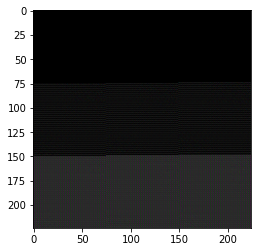

In [130]:
plt.imshow(x.reshape(224,224,3))